# Part I

## Loading Necessary Libraries

In [12]:
import pandas as pd
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

## Loading the data, headers & understanding the data

In [45]:
RAWDATAFOLDER = "Data"

def changeWorkingDirectory(path):
    os.chdir(path)

def ReadHeader(filename):
    """
    Keyword arguments:
    filename
    """
    fileObj = open("./"+RAWDATAFOLDER+"/"+filename, "r")
    header = fileObj.read().split("\n")
    return header

def ReadData(header,filename):
    rawdata = pd.read_csv("./"+RAWDATAFOLDER+"/"+filename,header = None)
    rawdata.columns = header
    return rawdata

#Change this directory to wherever the data folder is. This notebook should also be kept in the same folder.
changeWorkingDirectory("C:/Users/ilsa.baqai/GA Work")
header = ReadHeader("field_names.txt")
rawdata = ReadData(header,"breast-cancer.csv")
rawdata_copy = rawdata

### Some basic data sanity checks & information

In [6]:
print(rawdata.head(5)) #just to check top 5 rows 
print(rawdata.dtypes) #check the data type of columns
print(rawdata.isna().sum()) #check number of null values in the data
print(len(rawdata)) #check total number of datapoints
assert len(rawdata) == rawdata['ID'].nunique() #verify whether each row has unique data!

         ID diagnosis  radius_mean  radius_sd_error  radius_worst  \
0    842302         M        17.99            10.38        122.80   
1    842517         M        20.57            17.77        132.90   
2  84300903         M        19.69            21.25        130.00   
3  84348301         M        11.42            20.38         77.58   
4  84358402         M        20.29            14.34        135.10   

   texture_mean  texture_sd_error  texture_worst  perimeter_mean  \
0        1001.0           0.11840        0.27760          0.3001   
1        1326.0           0.08474        0.07864          0.0869   
2        1203.0           0.10960        0.15990          0.1974   
3         386.1           0.14250        0.28390          0.2414   
4        1297.0           0.10030        0.13280          0.1980   

   perimeter_sd_error  ...  concavity_worst  concave_points_mean  \
0             0.14710  ...            25.38                17.33   
1             0.07017  ...            24

### Comments on the data
* There are 32 varables in the dataset and 569 readings.here are *no missing values* so we will be required to handle them. Moreover, it is important to know that all variables are numeric (dtype: float64) so for an algorithm such as SVM, which is sensitive to the magnitude of the data, scaling or normalization will be required. In addition to that, dimensionality reduction will be required as since the dataset contains features about the same variable. For example, it is a possibility that area_mean, area_sd_error and area_worst are all correlating to the target variable in a similar manner. Furthmore it is also a possibility that some variables will be highly correlated to each other so correlation coefficient as well as significance testing with respect to the algorithms will also be necessary. Uniqueness in the data is also checked to make sure that all 569 are data points of unique patients. This can also be done directly by using the drop duplicates function in pandas.

### Distribution of Target Variable

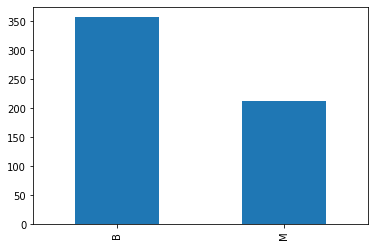

In [7]:
rawdata['diagnosis'].value_counts().plot(kind='bar')

In [8]:
print(rawdata['diagnosis'].value_counts())
print(rawdata['diagnosis'].value_counts(normalize=True) * 100)

B    357
M    212
Name: diagnosis, dtype: int64
B    62.741652
M    37.258348
Name: diagnosis, dtype: float64


### Comments on the data
The classificaton problem does not have class imbalance as well as Benign and Malignant are distributed 62.74% and 37.2% respectively. Had either of the category been between 1% - 10% in the total distributon then we would have also used techniques such as oversampling, undersampling or SMOTE to handle class imbalance. 

### Compute the mean and median smoothness and compactness for benign and malignant tumors - do they differ? Explain how you would identify this


(awaiting response for clarification)

In [9]:
B_compactness_mean = rawdata['compactness_mean'].loc[rawdata['diagnosis']=="B"]
M_compactness_mean = rawdata['compactness_mean'].loc[rawdata['diagnosis']=="M"]

## Bootstrapping Samples 

In [10]:
def BootstrapManual(all_data, sample_size, no_of_samples):
    all_samples = []
    for i in range(0,no_of_samples):
        all_samples.append(all_data.sample(n=sample_size,replace=True).reset_index().drop("index",axis=1))
    assert len(all_samples) == no_of_samples
    assert len(all_samples[0]) == sample_size
    return(all_samples)

all_samples = BootstrapManual(rawdata, 400, 2)

# alternative implementation using sklearn biult in function
bootstrap = resample(rawdata, replace=True, n_samples=4, random_state=1)

## Exploratory Analysis

### Correlation
Finding correlation fo variables using Pearson's corrleation. This will be done by using pandas alternatively can be done using scipy or statsmodels.

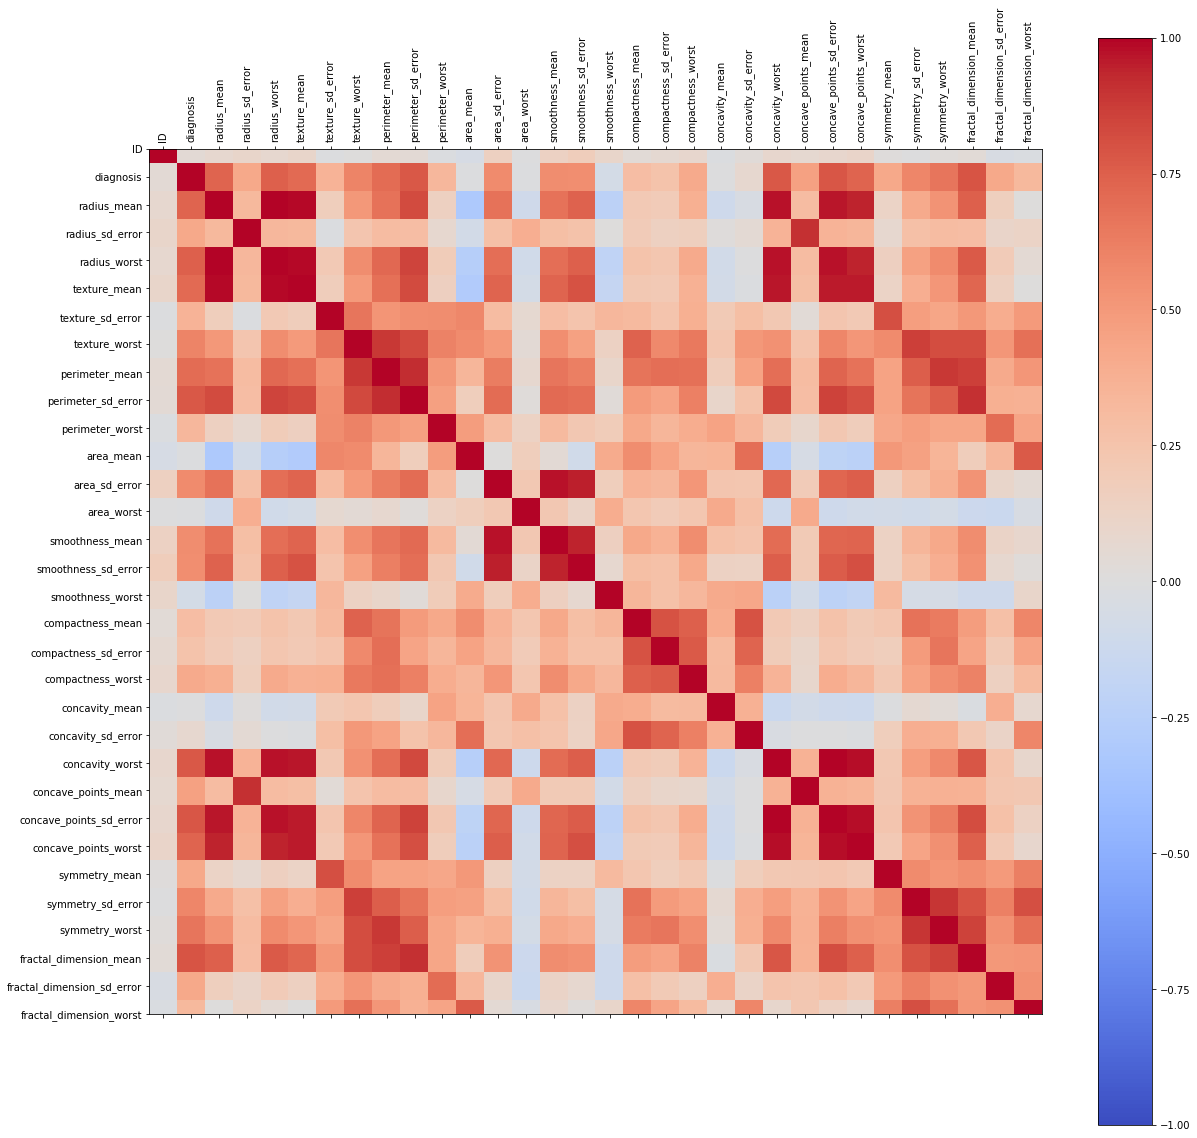

In [13]:
#Finding variables that are highly correlated with each other
rawdata['diagnosis'] = rawdata['diagnosis'].astype('category').cat.codes
numeric_data = rawdata.copy()
corr = numeric_data.corr()
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(rawdata.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(numeric_data.columns)
ax.set_yticklabels(numeric_data.columns)
plt.show()


### Comment on Correlation
We can observe that a number of varibles are highly direclty or inversely correlated with the target variables. It is important to remove highly correlated variables as highly directly correlated variables add no significant value to the learning of the machine learning algorithm. In the above code snippet, we first converted categorical column to numeric and since we only have numerical variables, we used pandas biult-in correlation function which find correlation coefficient. It by default used pearson's correlation metric for its calculation. Additionally, we also utilized matplotlib's built in functions to draw the heatmap.

From the heatmap, we can observe that radius_mean is highly directly correlated to concavity_worst as well as texture_mean. Additionlly,area_mean is moderately inversely correlated to texture_mean. Deriving such conclusions navigate us to understand which features overlap one other in correlations and which features do not. It will be tried to include as many uniquely behaving features as possible for the training of them machine learning algorithm.

It is also important to identify variables that are highly correlated with target variable. We can see that concavity_worse as well as fractal_dimension_mean are direclty correlated with the target variable. However, this particular method isnt suitable for cases where the target variable is categorical, as representing it as numbers makes the Pearson's Correlation method *assume* that each number defines a magnitude whereas its just an encoded label.

### Feature Selection based on Univariate Satistical Tests
In this section, an alternate to aforementioned heatmap, will be implemented to identify which variables are significant in determining whether the tumor is malignant or benign. Sklearn's feature selection module will be utilized for this. In the univariate analysis we have to define which particular statistical test will be used and based on that either top K variables or top N% variables can be selected as features. I will be using chi2 test as our target variable it categorical and selecting top 15 variables for the feature set.

In [14]:
X = rawdata_copy.drop(['ID','diagnosis'],axis=1)
y = rawdata_copy['diagnosis']
obj = SelectKBest(chi2, k=15)
X_new = obj.fit_transform(X, y)

#Once top 15 features w.r.t. target variables have been extracted, get_support function can be used to extract the column names
Sig_features = list(itertools.compress(X.columns, obj.get_support(True)))
print(Sig_features)

['radius_sd_error', 'radius_worst', 'texture_mean', 'texture_sd_error', 'texture_worst', 'perimeter_mean', 'perimeter_sd_error', 'perimeter_worst', 'area_mean', 'area_sd_error', 'area_worst', 'smoothness_mean', 'smoothness_sd_error', 'smoothness_worst']


From the above analysis, we can see that all 3 features of texture, perimeter, area and smoothness are significant whereas standard deviation and worst reading of radius were found significant as per the chi2 test.

### Plotting the significant features

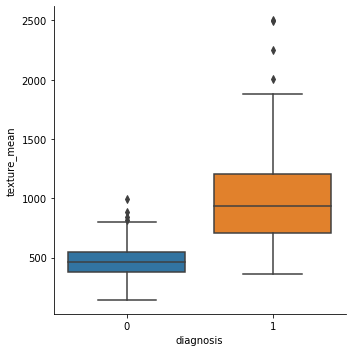

In [16]:
sns.catplot(x="diagnosis", y="texture_mean", kind="box", data=rawdata_copy);

As per the boxplot, we can see that the texture_mean for malignant (Labelled: 1 & shown in orange color) range is higher than the texture_mean range for benign tumors. This means that higher the texture_mean, the more likely is that the patient has malignant tumor. Our finding from the chi2 test has now also been supported by the visible distribution of the feature across the target variable

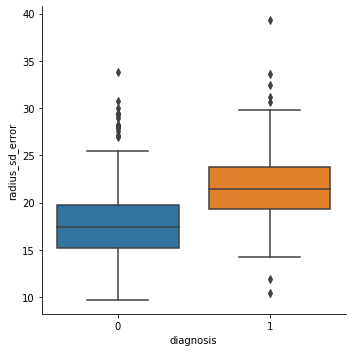

In [17]:
sns.catplot(x="diagnosis", y="radius_sd_error", kind="box", data=rawdata_copy);

When we perform a similar analysis on radius_sd_error, we can again see the significance of the feature in finding malignant tumors as it is evident from the plots that patients with malignant tumors have higher radius_sd_error.

## Predictive Modeling

### Train Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
print(len(X_train),len(X_test), len(y_train),len(y_test))

381 188 381 188


### Initializing Model Objects with Default Parameters

In [19]:
dTree = tree.DecisionTreeClassifier()
logReg = LogisticRegression()

### Seeing the default parameters set

In [20]:
print(dTree)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [21]:
print(logReg)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


### Cross Validation + Hyperparameter Tuning - GridSearch

Initializing a gridsearch object to execute exhaustively over the model and determine the best result!

Parameters that will be iterated over for Parameter Tuning


In [22]:
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[3, 4, 5, 8],
             "min_samples_leaf":[3,4,5,6,10,12,15]}

clf = GridSearchCV(dTree, parameters, cv=5)
clf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [3, 4, 5, 8],
                         

In [23]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 3}

In [24]:
clf.best_score_

0.9422572178477691

In [25]:
LRParameters = {"penalty":["elasticnet"],
                "tol":[0.0001,0.001,0.01,0.002],
                "solver":["saga"],
                "l1_ratio":[0.2,0.3,0.5,0.8],
                "verbose":[0],
                "max_iter":[150,200,250]
                }
clf2 =GridSearchCV(logReg,LRParameters, cv=5)
clf2.fit(X_train,y_train)

C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Co

C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Co

C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Co

C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Co

C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Co

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'l1_ratio': [0.2, 0.3, 0.5, 0.8],
                         'max_iter': [150, 200, 250], 'penalty': ['elasticnet'],
                         'solver': ['saga'],
                         'tol': [0.0001, 0.001, 0.01, 0.002], 'verbose': [0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
   

In [26]:
print(clf2.best_params_,clf2.best_score_)

{'l1_ratio': 0.2, 'max_iter': 250, 'penalty': 'elasticnet', 'solver': 'saga', 'tol': 0.0001, 'verbose': 0} 0.9002624671916011


In [27]:
LRParameters = {"penalty":["l1","l2"],
                "tol":[0.0001,0.001,0.01,0.002],
                "solver":["liblinear"],
                "verbose":[0],
                "max_iter":[100,150]
                }
clf3 =GridSearchCV(logReg,LRParameters, cv=5)
clf3.fit(X_train,y_train)
print(clf3.best_params_,clf3.best_score_)

C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packa

{'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.002, 'verbose': 0} 0.9448818897637795


### GirdSearch Including Cross Validation & Train Test

In [28]:
predictions_dtree = clf.predict(X_test)
predictions_LR1 = clf2.predict(X_test)
predictions_LR2 = clf3.predict(X_test)

### Determine Goodness of Fit

In [29]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions_dtree).ravel()
print(tn, fp, fn, tp) #extracting true negatives, false positives, false negatives and true positives

116 5 6 61


what is the precision and recall of each class? We can compute that from the scores above or by using sklearn's classification Report!

In [31]:
print("Classification Report for Decision Tree")
print(classification_report(y_test, predictions_dtree, target_names=["True","False"]))

Classification Report for Decision Tree
              precision    recall  f1-score   support

        True       0.95      0.96      0.95       121
       False       0.92      0.91      0.92        67

    accuracy                           0.94       188
   macro avg       0.94      0.93      0.94       188
weighted avg       0.94      0.94      0.94       188



In [32]:
print("Classification Report for LR1")
print(classification_report(y_test, predictions_LR1, target_names=["True","False"]))

Classification Report for LR1
              precision    recall  f1-score   support

        True       0.94      0.98      0.96       121
       False       0.97      0.90      0.93        67

    accuracy                           0.95       188
   macro avg       0.96      0.94      0.95       188
weighted avg       0.95      0.95      0.95       188



In [33]:
print("Classification Report for LR2")
print(classification_report(y_test, predictions_LR2, target_names=["True","False"]))

Classification Report for LR2
              precision    recall  f1-score   support

        True       0.98      0.98      0.98       121
       False       0.96      0.96      0.96        67

    accuracy                           0.97       188
   macro avg       0.97      0.97      0.97       188
weighted avg       0.97      0.97      0.97       188



### Comments on the models & overfitting
It can be observed that all three models are performing good for training and testing samples, both. We are able to achieve a max of 97% accuracy however in all 3 models, we are observing that they all are overfitting. This could be due to various reasons, one being the dataset being small for the complexity of the algorithm(s) selected. Another reason could be that for Logistic Regression, the max_iteration parameter is set to a high value, allowing unnecessary & excessive iterations over the data which makes the model prone to over fitting. It is also to imperative to note that both precision and recall are above 95% for both logistic rehression algorithms, again highlighting possible overfitting of the model. 

### Identifying important predictive variables for model
For this task, in order to identify which variable is being most informative in identifying the underlying pattern, I will be using SelectFromModel utility in sklearn.feature_selection module. It extracts information based on the importance weights of feature in the model. 

['radius_sd_error', 'radius_worst', 'texture_mean', 'texture_sd_error', 'texture_worst', 'perimeter_mean', 'perimeter_sd_error', 'perimeter_worst']


C:\Users\ilsa.baqai\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[Text(204.01875, 203.85, 'X[20] <= 16.795\ngini = 0.468\nsamples = 569\nvalue = [357, 212]'),
 Text(125.55000000000001, 176.67000000000002, 'X[27] <= 0.136\ngini = 0.159\nsamples = 379\nvalue = [346, 33]'),
 Text(57.54375, 149.49, 'X[29] <= 0.055\ngini = 0.03\nsamples = 333\nvalue = [328, 5]'),
 Text(47.081250000000004, 122.31, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(68.00625000000001, 122.31, 'X[13] <= 38.605\ngini = 0.024\nsamples = 332\nvalue = [328, 4]'),
 Text(41.85, 95.13, 'X[14] <= 0.003\ngini = 0.012\nsamples = 319\nvalue = [317, 2]'),
 Text(20.925, 67.94999999999999, 'X[14] <= 0.003\ngini = 0.245\nsamples = 7\nvalue = [6, 1]'),
 Text(10.4625, 40.77000000000001, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(31.387500000000003, 40.77000000000001, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(62.775000000000006, 67.94999999999999, 'X[21] <= 33.27\ngini = 0.006\nsamples = 312\nvalue = [311, 1]'),
 Text(52.3125, 40.77000000000001, 'gini = 0.0\nsamples = 292\nvalue

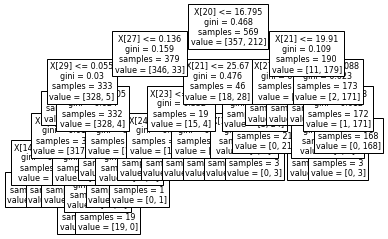

In [39]:
selector = SelectFromModel(estimator=logReg).fit(X, y)
# print(selector.estimator_.coef_)
# print(selector.get_support(True))
logReg_Features = list(itertools.compress(X.columns, selector.get_support(True)))
print(logReg_Features)

obj = dTree.fit(X,y)
tree.plot_tree(obj, fontsize=8) 

In [44]:
list(X.columns)[20]

'concavity_worst'

For logistic regression, I utilized the selectfrommodel utility present in sklearn and from that I extracted the top performing features in logistic regression. The top features were radius, texture and perimeter for logistic regression.  
For decision tree, Iextracted the rules from the tree object and observed that maximum information gain was from the 20th feature which was concavity_worst as it gave gini index of 0.468.

## Explanation

* For Technical Audience:
It is important to understand that determining malignant or benign tumors with total data size of 569 without overfitting is a difficult task. Additionally, since this specific ML task is related to healthcare that too cancer, rate of false negatives needs to be controlled and looked out for as false negatives would mean that people with malignant tumors not getting identified and the patient not getting the required treatment done. High false positives can also result if the next step after knowing the tumor category is medication as the patient with benign tumor will be getting medication suited for malignant tumor.  
In order to further make the model robust, more complext classification algorithms such as Randomforest can be used however, it is also expected to overfit as it requires a lot more data. Additionally, feature scaling and normalization can also be done to make Support vector machine classifier work on the data set as SVC's non- linear kernels are better performing than LR in terms of identifying non-linear patterns.


* Non-Technical audience: 
The analysis performed on the dataset, comprised of a basic ML pipeline which included; Data Understanding, Exploratory Data Analysis, Feature selection & Modeling.  
For each phase biult in python modules were used as well as manual implementation of functions. Initial understanding of the data consisted of extracting basic information _about_ the data such as the number of data points, searching for missing values and checking for duplication.  
Following that, an exploratory analysis phase comprising of finding correlated feature points to make sure that the model receives only those variables that add unique information. In this phase, significant features ie. features that were important to determing the type of tumor were also identified. The selected features were then used to train multiple algorithms. One of the algorithm is Decision Tree classifer, which works on splitting the data based on how much information about the target variable each split is going to give.  
A clear way to understand that is to think that if 10 small pearls each having their own properties but belonging to two different categories. We need to find properties of the pearls related to each categry. So maybe, pearls with radius > 2mm frst get separated giving us a set with 95% pearls from one category, this means that the data has been split in such a way that the resulting subset had the max number of pearls from one category ie was least polluted with mixture of categories. This is exaclty how decision tree algorith works, on the basis of _least pollution_ in the resulting set, different nested conditions are found and set hence forming a tree like structure. Following each condition, one reaches a resulting prediction for a data point hence the algorithm is called a _Decision Tree_ algorithm.  
Important variables which were helpful in training the algorithm were radius_mean, smoothness and concavity. It is logically understandable as the tissues and its medical imaging will not be very clear in malignant reports due to the developed tumor however for benign the smoothness etc factor might be different as the tissues will be differnetl formed in the picture.

# Part II
Feedback on code snippets

## Code sample I
1. __Code:__  
    * All the imports should have been together at the top.
    * The variable names need to be self explanatory such as changing _d_ to raw_data.
    * The splitting of Predictors and target variables need to have clear naming convention, they are not a part of _x_ hence cannot be named x1 & x2, rather its better to name them X & Y or predictors & Target. 
    * 
2. __Methodology:__    
    * Model has a number of parameters that could have been fine tuned to derive better results
    * Cross validation has been set to 1 which defeats the purpose of having cross validation in the first place, cv=1 is same as having a basic one train/test split and training the model on the training set and testing on the test split. It is always advised to have more splits in order to make the model generalizable.
    * Using mean absolute error for evaluation does not help in identifying large errors. Root mean squared error would have helped more in that. 
    * PArameter tuning of cross_val_score could also have been done.
3. __Conceptual Understanding:__  
    * Student is advised to test the algorithm's performance with other predictors as well as with higher cross validation value
    * It is also suggested to practice python PEP8 standards in coding style to improve code readability.
    * The student can also read how MSE error is calculcated and what is the effect and disadvantages of further averaging the scores of each cross validation iteration. 
    * The student should also read documentation of the function that he/she uses to better understand the possible parameters that can be fine tuned and also to better understand how the said function/utility works.

## Code sample II
1. __Code:__  
    * The naming convention of the code snippet is well thougt.
    * The imports are at the right place and are all together, which again is a good practice. 

2. __Methodology:__    
    * Model has a number of parameters that could have been fine tuned to derive better results
    * Cross validation has been set to 5 which is also the default value so had this parameter not been defined like this, it still would have performed the same.
    * Using mean absolute error for evaluation does not help in identifying large errors. Root mean squared error would have helped more in that. 
    * Parameter tuning of cross_val_score could also have been done.
3. __Conceptual Understanding:__  
    * Student is advised to test the algorithm's performance with other predictors as well as with higher cross validation value
    * The student can also read how MSE error is calculcated and what is the effect and disadvantages of further averaging the scores of each cross validation iteration. 
    * The student should also read documentation of the function that he/she uses to better understand the possible parameters that can be fine tuned and also to better understand how the said function/utility works.